In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

from dyck_k_generator import constants

In [3]:
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

'cuda:0'

In [4]:
if device == "mps":
    torch.mps.empty_cache()
elif device == "cuda:0":
    torch.cuda.empty_cache()

In [5]:
torch.manual_seed(42)

In [6]:
k = 1

In [7]:
from dyck_k_generator.generator import generate_dataset

path = generate_dataset(
    n=1000,
    k=k,
    max_length=10,
    balanced=0.55,
)

File data/dyck-1_1000-samples_10-len_p055.jsonl already exists.


In [8]:
VOCAB = "".join(
    ["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]]
)
VOCAB

'()'

In [9]:
from dataset.dataset import DyckLanguageDataset

In [10]:
dataset = DyckLanguageDataset(path, VOCAB).to(device)

Loaded 1000 samples from data/dyck-1_1000-samples_10-len_p055.jsonl


Tokenizing strings: 100%|██████████| 1000/1000 [00:00<00:00, 693273.39it/s]


In [11]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = int(0.15 * train_size)
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

In [12]:
from torch.utils.data import DataLoader

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# Hooked Transformer (Bidirectional mask) - Dyck-1 dataset


In [14]:
from transformer.hooked_transformer import (
    TransformerClassifier,
    TransformerClassifierConfig,
    causal_mask,
    pad_token_mask,
)

In [15]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=256,
    n_heads=1,
    dim_ff=384,
    n_layers=1,
    n_classes=2,
    max_seq_len=10,
)

In [16]:
model_bidirectional = TransformerClassifier(model_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matiasmolinolo. Use `wandb login --relogin` to force relogin


In [17]:
model_bidirectional.to(device)

TransformerClassifier(
  (embedding): Embedding(5, 256)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): EncoderBlock(
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=256, out_features=256, bias=True)
          (k_linear): Linear(in_features=256, out_features=256, bias=True)
          (v_linear): Linear(in_features=256, out_features=256, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (residual_dropout): Dropout(p=0.1, inplace=False)
          (attn): ScaledDotProductAttention()
          (out): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=256, out_features=384, bias=True)
          (1): Dropout(p=0.1, inplace=False)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=384, out_features=256, bias=True)
        )
        (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((256,), 

In [18]:
import torch.optim as optim

crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model_bidirectional.parameters(), lr=1e-4)

In [19]:
train_loss, train_acc, val_loss, val_acc = model_bidirectional.train_model(
    device=device,
    epochs=20,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0970 | Train Acc: 53.00%
Val Loss: 1.3664 | Val Acc: 53.33%
Epoch 2/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.8756 | Train Acc: 56.12%
Val Loss: 1.3195 | Val Acc: 53.33%
Epoch 3/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9105 | Train Acc: 56.00%
Val Loss: 1.3941 | Val Acc: 54.17%
Epoch 4/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1713 | Train Acc: 54.25%
Val Loss: 1.3754 | Val Acc: 54.17%
Epoch 5/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1585 | Train Acc: 52.75%
Val Loss: 1.3379 | Val Acc: 53.33%
Epoch 6/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.8885 | Train Acc: 53.25%
Val Loss: 1.2925 | Val Acc: 61.67%
Epoch 7/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.7996 | Train Acc: 52.12%
Val Loss: 1.2824 | Val Acc: 69.17%
Epoch 8/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9201 | Train Acc: 54.00%
Val Loss: 1.2622 | Val Acc: 69.17%
Epoch 9/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 7.6826 | Train Acc: 60.38%
Val Loss: 0.8452 | Val Acc: 100.00%
Epoch 10/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 4.0087 | Train Acc: 95.12%
Val Loss: 0.3508 | Val Acc: 100.00%
Epoch 11/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 1.2091 | Train Acc: 100.00%
Val Loss: 0.0452 | Val Acc: 100.00%
Epoch 12/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.2560 | Train Acc: 100.00%
Val Loss: 0.0100 | Val Acc: 100.00%
Epoch 13/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1019 | Train Acc: 99.88%
Val Loss: 0.0050 | Val Acc: 100.00%
Epoch 14/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0528 | Train Acc: 100.00%
Val Loss: 0.0032 | Val Acc: 100.00%
Epoch 15/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0374 | Train Acc: 100.00%
Val Loss: 0.0022 | Val Acc: 100.00%
Epoch 16/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0280 | Train Acc: 100.00%
Val Loss: 0.0017 | Val Acc: 100.00%
Epoch 17/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0228 | Train Acc: 100.00%
Val Loss: 0.0012 | Val Acc: 100.00%
Epoch 18/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0182 | Train Acc: 100.00%
Val Loss: 0.0009 | Val Acc: 100.00%
Epoch 19/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0131 | Train Acc: 100.00%
Val Loss: 0.0007 | Val Acc: 100.00%
Epoch 20/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0104 | Train Acc: 100.00%
Val Loss: 0.0005 | Val Acc: 100.00%


In [20]:
test_loss, test_acc = model_bidirectional.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.0029 | Test Acc: 100.00%


test/acc,▁▁▁▁▁▁▁▁▁▁
test/loss,▄█▄▅▅▄▁▇▅▅
test_acc,▁
test_loss,▁
train/acc,▂▂▃▃▂▂▁▂▂▂▂▂▂▂▂▂▂▂█▇████████████████████
train/loss,██▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▂▂▂▃▂▂▂▁▂▂▃▄▄▃▄████████████████████████
val/loss,█▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▅▅▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/acc,100.0
test/loss,0.0003
test_acc,100.0


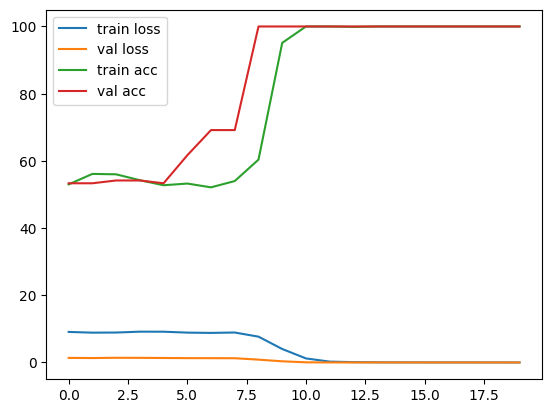

In [21]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

# Hooked Transformer (causal mask) - Dyck-1 dataset

In [22]:
model_causal = TransformerClassifier(model_config).to(device)

In [23]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model_causal.parameters(), lr=1e-4)

In [24]:
train_loss, train_acc, val_loss, val_acc = model_causal.train_model(
    device=device,
    epochs=50,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="causal",
)

Epoch 1/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1115 | Train Acc: 54.00%
Val Loss: 1.3842 | Val Acc: 53.33%
Epoch 2/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1152 | Train Acc: 53.75%
Val Loss: 1.3823 | Val Acc: 53.33%
Epoch 3/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1356 | Train Acc: 50.12%
Val Loss: 1.3816 | Val Acc: 53.33%
Epoch 4/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1811 | Train Acc: 49.62%
Val Loss: 1.3855 | Val Acc: 53.33%
Epoch 5/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9768 | Train Acc: 52.12%
Val Loss: 1.4027 | Val Acc: 53.33%
Epoch 6/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0725 | Train Acc: 54.12%
Val Loss: 1.4011 | Val Acc: 46.67%
Epoch 7/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1640 | Train Acc: 52.50%
Val Loss: 1.3826 | Val Acc: 53.33%
Epoch 8/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9947 | Train Acc: 50.88%
Val Loss: 1.3955 | Val Acc: 53.33%
Epoch 9/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9699 | Train Acc: 55.62%
Val Loss: 1.3919 | Val Acc: 46.67%
Epoch 10/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1665 | Train Acc: 50.50%
Val Loss: 1.3925 | Val Acc: 53.33%
Epoch 11/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0771 | Train Acc: 51.12%
Val Loss: 1.3925 | Val Acc: 53.33%
Epoch 12/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9785 | Train Acc: 55.00%
Val Loss: 1.3862 | Val Acc: 53.33%
Epoch 13/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9547 | Train Acc: 54.12%
Val Loss: 1.3816 | Val Acc: 53.33%
Epoch 14/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0731 | Train Acc: 52.62%
Val Loss: 1.3822 | Val Acc: 53.33%
Epoch 15/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0481 | Train Acc: 51.12%
Val Loss: 1.4138 | Val Acc: 53.33%
Epoch 16/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0716 | Train Acc: 51.75%
Val Loss: 1.3877 | Val Acc: 53.33%
Epoch 17/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0313 | Train Acc: 54.25%
Val Loss: 1.3823 | Val Acc: 53.33%
Epoch 18/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9306 | Train Acc: 53.37%
Val Loss: 1.4001 | Val Acc: 53.33%
Epoch 19/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1142 | Train Acc: 52.50%
Val Loss: 1.3893 | Val Acc: 46.67%
Epoch 20/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0217 | Train Acc: 53.62%
Val Loss: 1.3945 | Val Acc: 53.33%
Epoch 21/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1566 | Train Acc: 48.12%
Val Loss: 1.3992 | Val Acc: 53.33%
Epoch 22/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0734 | Train Acc: 55.00%
Val Loss: 1.3852 | Val Acc: 53.33%
Epoch 23/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1175 | Train Acc: 48.50%
Val Loss: 1.3884 | Val Acc: 53.33%
Epoch 24/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0516 | Train Acc: 50.50%
Val Loss: 1.3891 | Val Acc: 53.33%
Epoch 25/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1136 | Train Acc: 53.25%
Val Loss: 1.3808 | Val Acc: 53.33%
Epoch 26/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1669 | Train Acc: 49.25%
Val Loss: 1.4315 | Val Acc: 53.33%
Epoch 27/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0346 | Train Acc: 54.62%
Val Loss: 1.3828 | Val Acc: 53.33%
Epoch 28/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0533 | Train Acc: 50.75%
Val Loss: 1.3898 | Val Acc: 53.33%
Epoch 29/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0499 | Train Acc: 55.25%
Val Loss: 1.3820 | Val Acc: 53.33%
Epoch 30/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0909 | Train Acc: 51.50%
Val Loss: 1.3960 | Val Acc: 53.33%
Epoch 31/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0779 | Train Acc: 53.37%
Val Loss: 1.3832 | Val Acc: 53.33%
Epoch 32/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0412 | Train Acc: 53.62%
Val Loss: 1.3880 | Val Acc: 53.33%
Epoch 33/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0608 | Train Acc: 53.37%
Val Loss: 1.3818 | Val Acc: 53.33%
Epoch 34/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0723 | Train Acc: 47.88%
Val Loss: 1.3986 | Val Acc: 53.33%
Epoch 35/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0523 | Train Acc: 54.87%
Val Loss: 1.3825 | Val Acc: 53.33%
Epoch 36/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0357 | Train Acc: 50.38%
Val Loss: 1.3859 | Val Acc: 53.33%
Epoch 37/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0611 | Train Acc: 55.12%
Val Loss: 1.3828 | Val Acc: 53.33%
Epoch 38/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0467 | Train Acc: 53.62%
Val Loss: 1.3837 | Val Acc: 53.33%
Epoch 39/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9853 | Train Acc: 53.12%
Val Loss: 1.3815 | Val Acc: 53.33%
Epoch 40/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0172 | Train Acc: 52.62%
Val Loss: 1.3866 | Val Acc: 53.33%
Epoch 41/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0477 | Train Acc: 55.62%
Val Loss: 1.3824 | Val Acc: 53.33%
Epoch 42/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0339 | Train Acc: 53.75%
Val Loss: 1.3845 | Val Acc: 53.33%
Epoch 43/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0456 | Train Acc: 52.00%
Val Loss: 1.3881 | Val Acc: 53.33%
Epoch 44/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0172 | Train Acc: 54.87%
Val Loss: 1.3827 | Val Acc: 53.33%
Epoch 45/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9691 | Train Acc: 54.50%
Val Loss: 1.3812 | Val Acc: 53.33%
Epoch 46/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0214 | Train Acc: 53.37%
Val Loss: 1.3843 | Val Acc: 53.33%
Epoch 47/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9856 | Train Acc: 55.38%
Val Loss: 1.3830 | Val Acc: 53.33%
Epoch 48/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9933 | Train Acc: 51.62%
Val Loss: 1.3911 | Val Acc: 53.33%
Epoch 49/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9952 | Train Acc: 54.25%
Val Loss: 1.3827 | Val Acc: 53.33%
Epoch 50/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9729 | Train Acc: 54.12%
Val Loss: 1.3818 | Val Acc: 53.33%


In [25]:
test_loss, test_acc = model_causal.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="causal",
)

  0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 6.7963 | Test Acc: 60.00%


test/acc,█▅▃▁▂▂▂▁▁▂
test/loss,▁▄██▄▄▄██▁
test_acc,▁
test_loss,▁
train/acc,▆▆▆▃▇▄▄▂▅▆▆▆▄▆▅▃▃▆▃▄▃▆█▄▅▅▁▇▃▆█▃▆▆▇▆▅▆▄▅
train/loss,▄▄▃▃▅█▂▃▃▃▂▂▃▃▂▂▄▁▃▄▂▂▁▄▃▃▃▂▃▂▁▃▃▃▂▃▂▄▁▃
val/acc,▇▁▅▅▂▇▅▂█▅▅▅▂▅▅▅▆▅▅▁▆▅▅▇▅▅▆▅▅▅▅▅▅▅▅▄▅▅▂▅
val/loss,▂▇▃▃▅▃▆▄▁▄▃▄█▃▆▅▄▄▄▅▆▄▅▃▃▄▄▃▃▄▄▄▄▄▄▄▄▄▆▃
test/acc,60.0
test/loss,0.65381
test_acc,60.0


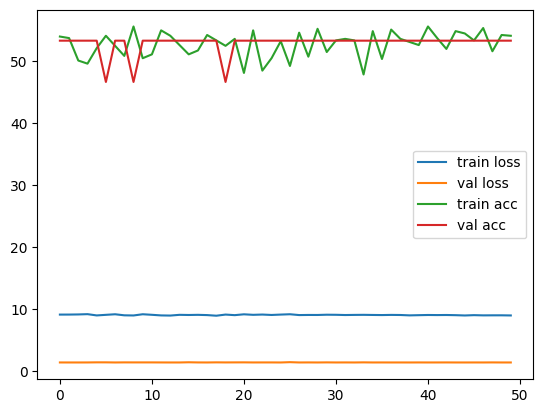

In [26]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

# Attention plots:


In [27]:
batch = next(iter(test_dataloader))
strings, labels, tokens = batch

mask = pad_token_mask(tokens)
attn_matrices = model_bidirectional.get_attn_matrices(tokens, mask)

In [28]:
from transformer_viz.visualizer import min_max_normalize, plot_attn_matrices

In [29]:
from dataset.dataset import DyckLanguageTokenizer
from dyck_k_generator.checker import is_dyck_word

In [30]:
batch = (
    ")))))))(((((((",
    is_dyck_word(")))))))(((((((", k=1),
    DyckLanguageTokenizer(VOCAB).tokenize(")))))))(((((((").to(device),
)
batch

Tokenizing strings: 100%|██████████| 1/1 [00:00<00:00, 31068.92it/s]


(')))))))(((((((',
 False,
 tensor([[0., 4., 4., 4., 4., 4., 4., 4., 3., 3., 3., 3., 3., 3., 3., 2.]],
        device='cuda:0'))

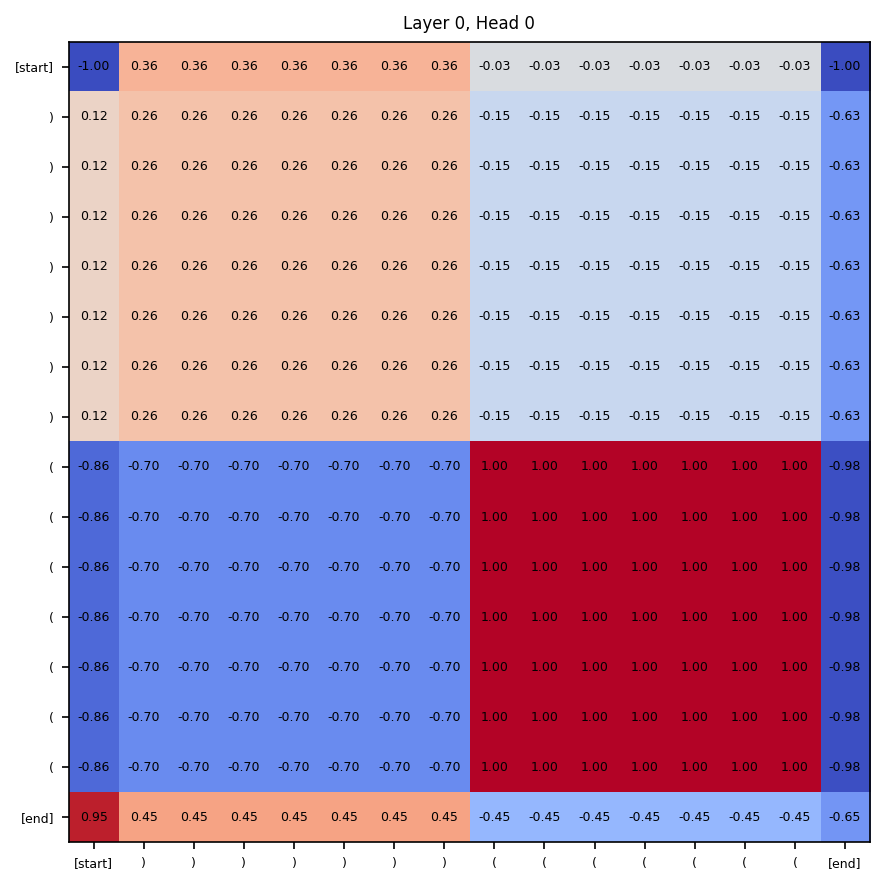

In [31]:
plot_attn_matrices(VOCAB, batch, model_bidirectional, min_max_normalize, pad_token_mask)

# Hooked Transformer (Bidirectional mask) - Dyck-3 dataset


In [34]:
k = 3

In [35]:
path = generate_dataset(
    n=5_000,
    k=3,
    min_length=8,
    max_length=8,
    balanced=0.6,
)

File data/dyck-3_5000-samples_8-len_p06.jsonl already exists.


In [36]:
VOCAB = "".join(
    ["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]]
)
VOCAB

'()[]{}'

In [37]:
dataset_dyck_2 = DyckLanguageDataset(path, VOCAB).to(device)

Loaded 5000 samples from data/dyck-3_5000-samples_8-len_p06.jsonl


Tokenizing strings: 100%|██████████| 5000/5000 [00:00<00:00, 606990.45it/s]


In [38]:
train_size = int(0.8 * len(dataset_dyck_2))
val_size = int(0.15 * train_size)
test_size = len(dataset_dyck_2) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset_dyck_2, [train_size, val_size, test_size]
)

In [39]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [40]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=512,
    n_heads=1,
    dim_ff=1024,
    n_layers=1,
    n_classes=2,
    max_seq_len=10,
)

In [41]:
model = TransformerClassifier(model_config).to(device)

In [42]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [43]:
train_loss, train_acc, val_loss, val_acc = model.train_model(
    device=device,
    epochs=15,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 24.1620 | Train Acc: 83.60%
Val Loss: 0.8914 | Val Acc: 99.67%
Epoch 2/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 3.9090 | Train Acc: 99.15%
Val Loss: 0.2276 | Val Acc: 99.67%
Epoch 3/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 2.8745 | Train Acc: 99.15%
Val Loss: 0.1989 | Val Acc: 99.67%
Epoch 4/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 2.7714 | Train Acc: 99.15%
Val Loss: 0.3047 | Val Acc: 99.67%
Epoch 5/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 2.6621 | Train Acc: 99.15%
Val Loss: 0.1848 | Val Acc: 99.67%
Epoch 6/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 2.6519 | Train Acc: 99.15%
Val Loss: 0.1847 | Val Acc: 99.67%
Epoch 7/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 2.7503 | Train Acc: 99.15%
Val Loss: 0.1894 | Val Acc: 99.67%
Epoch 8/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 2.6607 | Train Acc: 99.15%
Val Loss: 0.1812 | Val Acc: 99.67%
Epoch 9/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 2.7653 | Train Acc: 99.15%
Val Loss: 0.1796 | Val Acc: 99.67%
Epoch 10/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 2.6348 | Train Acc: 99.15%
Val Loss: 0.1781 | Val Acc: 99.67%
Epoch 11/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 2.6538 | Train Acc: 99.15%
Val Loss: 0.1697 | Val Acc: 99.67%
Epoch 12/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 2.0398 | Train Acc: 99.15%
Val Loss: 0.0944 | Val Acc: 99.67%
Epoch 13/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.7568 | Train Acc: 99.48%
Val Loss: 0.0092 | Val Acc: 100.00%
Epoch 14/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.1078 | Train Acc: 100.00%
Val Loss: 0.0031 | Val Acc: 100.00%
Epoch 15/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0521 | Train Acc: 100.00%
Val Loss: 0.0015 | Val Acc: 100.00%


In [44]:
test_loss, test_acc = model.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/50 [00:00<?, ?it/s]

Test Loss: 0.0212 | Test Acc: 100.00%


test/acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/loss,▁▁▁▁▁▁▁▁▁▁▁▄▁▅▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train/acc,▁▄▅█████████████████████████████████████
train/loss,█▅▂▁▁▃▁▁▁▂▂▁▂▁▂▂▁▁▁▁▁▁▂▁▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁
val/acc,▁▅▅█▆▅█▅█▆▆▁▃▅▅▅█▆▅▅▆▅▅▅█▆▅█▅▁▁▅████████
val/loss,█▅▆▂▁▂▁▅▁▁▁▁▅▁▁▁▁▅▁▅▁▁▁▁▁▅▁▁▅▁▁▁▁▁▁▁▁▁▁▁
test/acc,100.0
test/loss,4e-05
test_acc,100.0


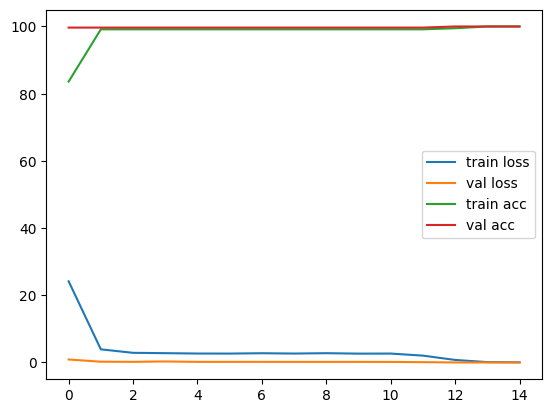

In [45]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

In [46]:
batch = next(iter(test_dataloader))
batch

[('(()){}{}',
  '[][][[]]',
  '{}[[]]()',
  '[([])[]]',
  '}((}[)))',
  '}((}[)))',
  '}((}[)))',
  '{()[()]}'),
 tensor([1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0'),
 tensor([[0., 3., 3., 4., 4., 7., 8., 7., 8., 2.],
         [0., 5., 6., 5., 6., 5., 5., 6., 6., 2.],
         [0., 7., 8., 5., 5., 6., 6., 3., 4., 2.],
         [0., 5., 3., 5., 6., 4., 5., 6., 6., 2.],
         [0., 8., 3., 3., 8., 5., 4., 4., 4., 2.],
         [0., 8., 3., 3., 8., 5., 4., 4., 4., 2.],
         [0., 8., 3., 3., 8., 5., 4., 4., 4., 2.],
         [0., 7., 3., 4., 5., 3., 4., 6., 8., 2.]], device='cuda:0')]

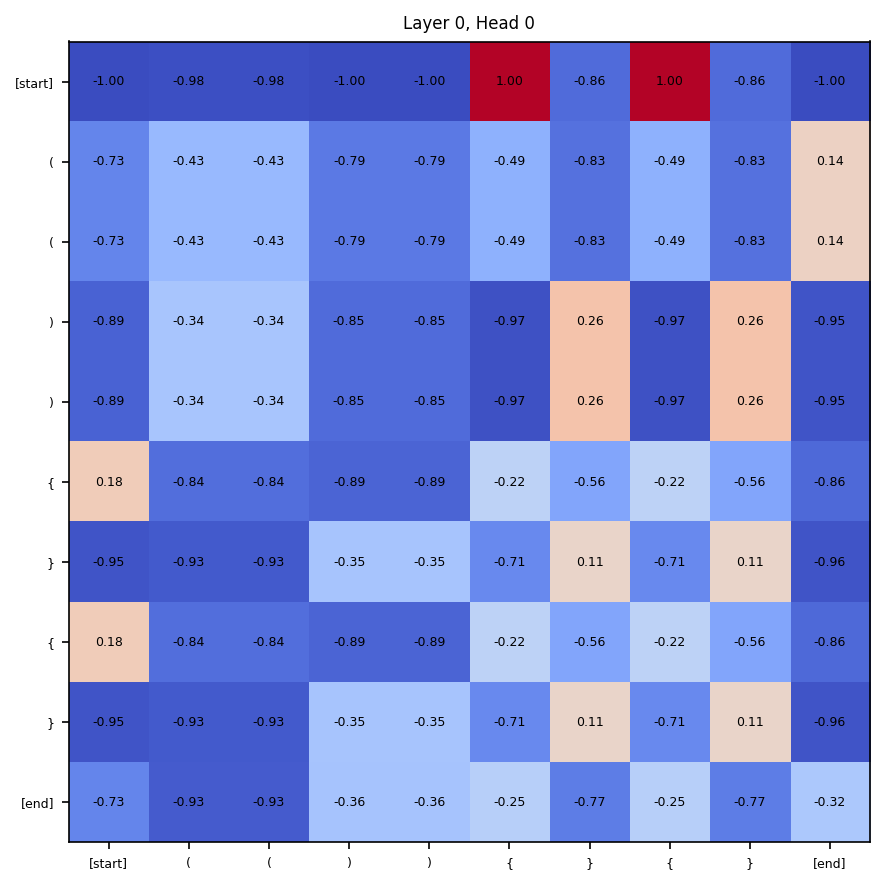

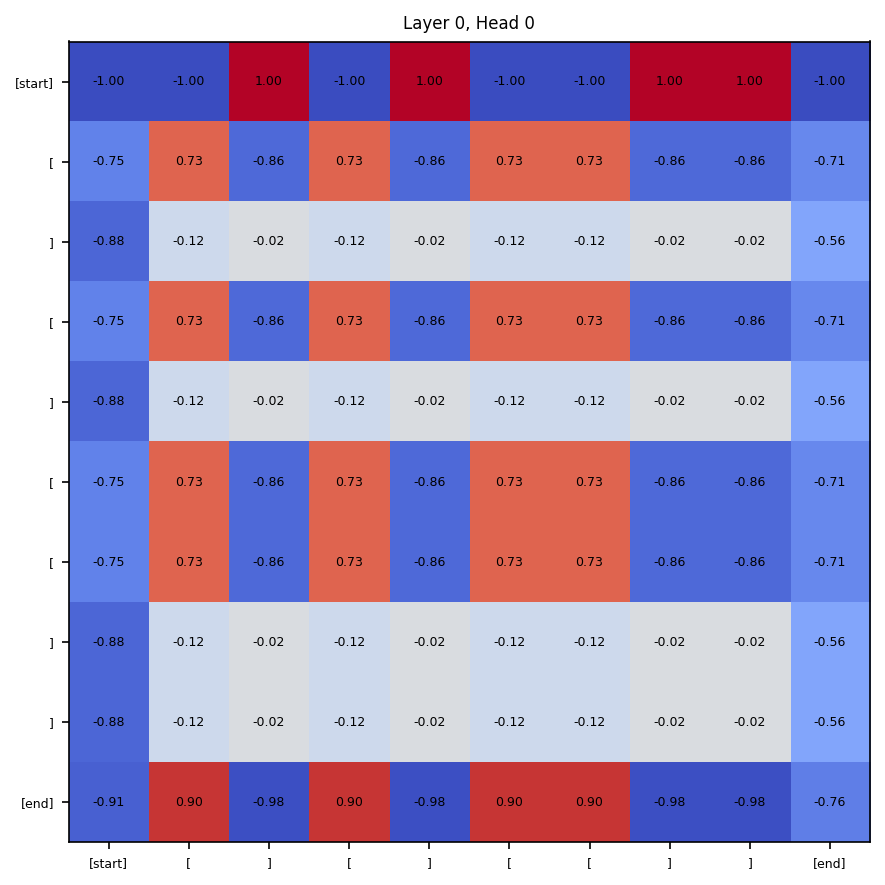

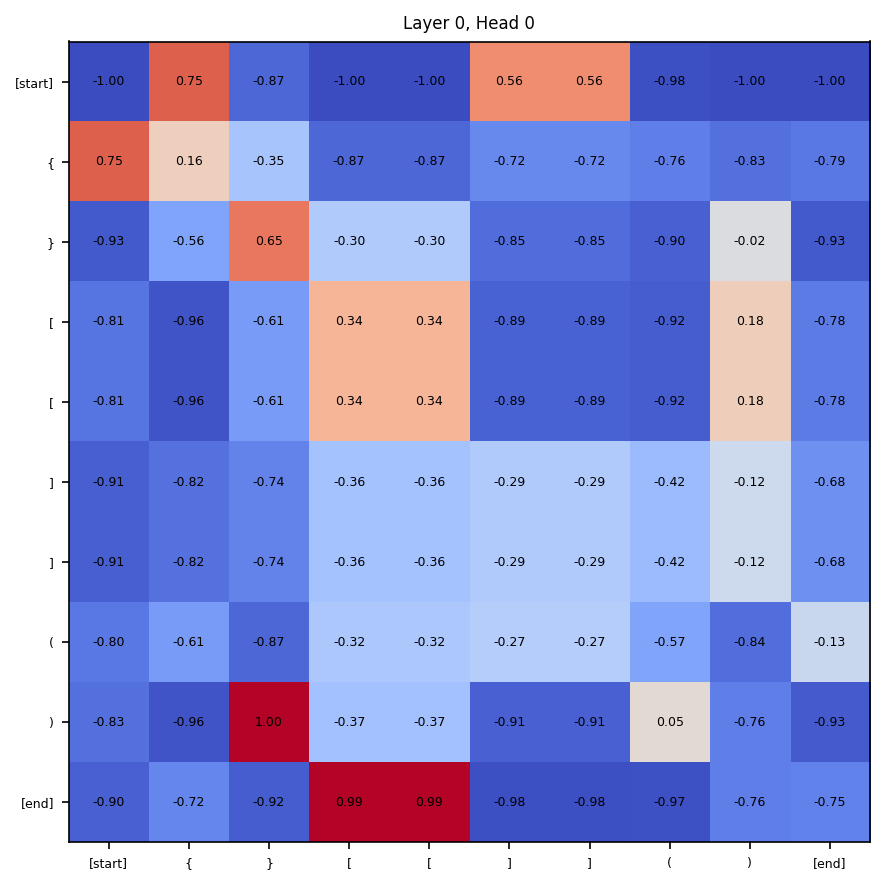

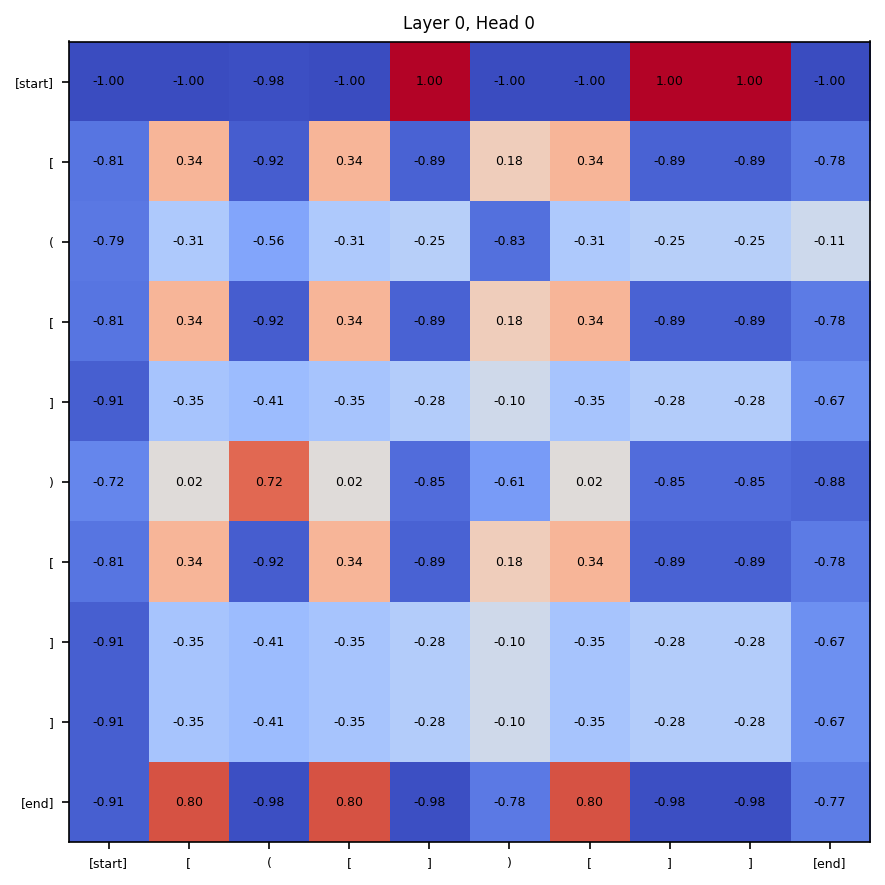

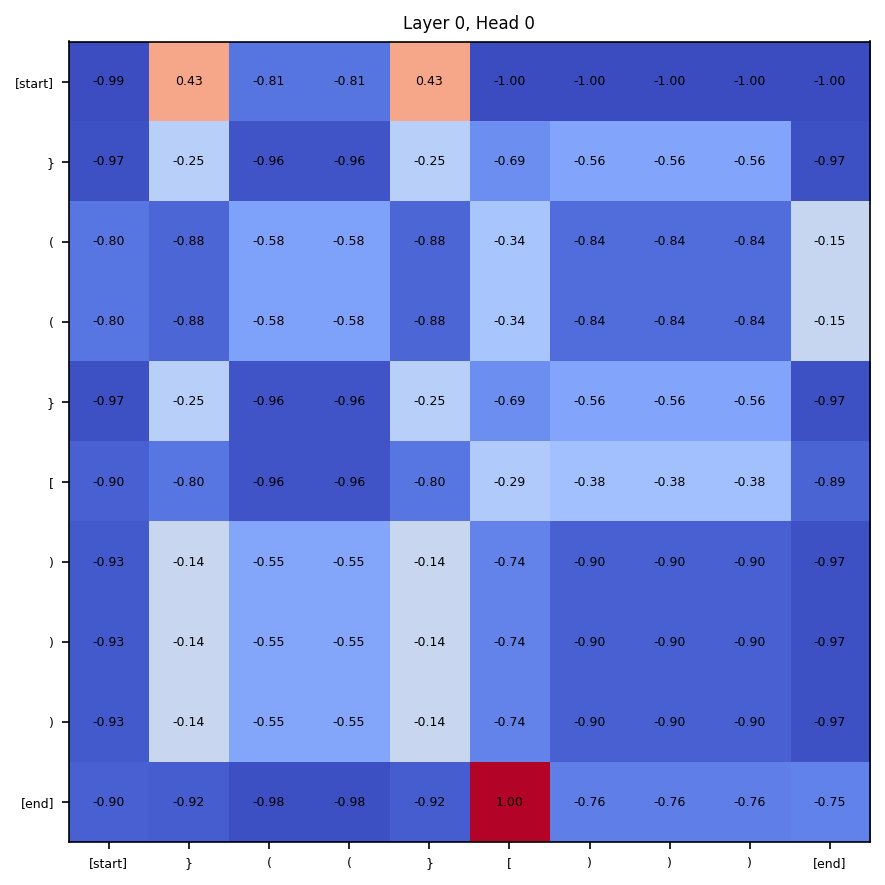

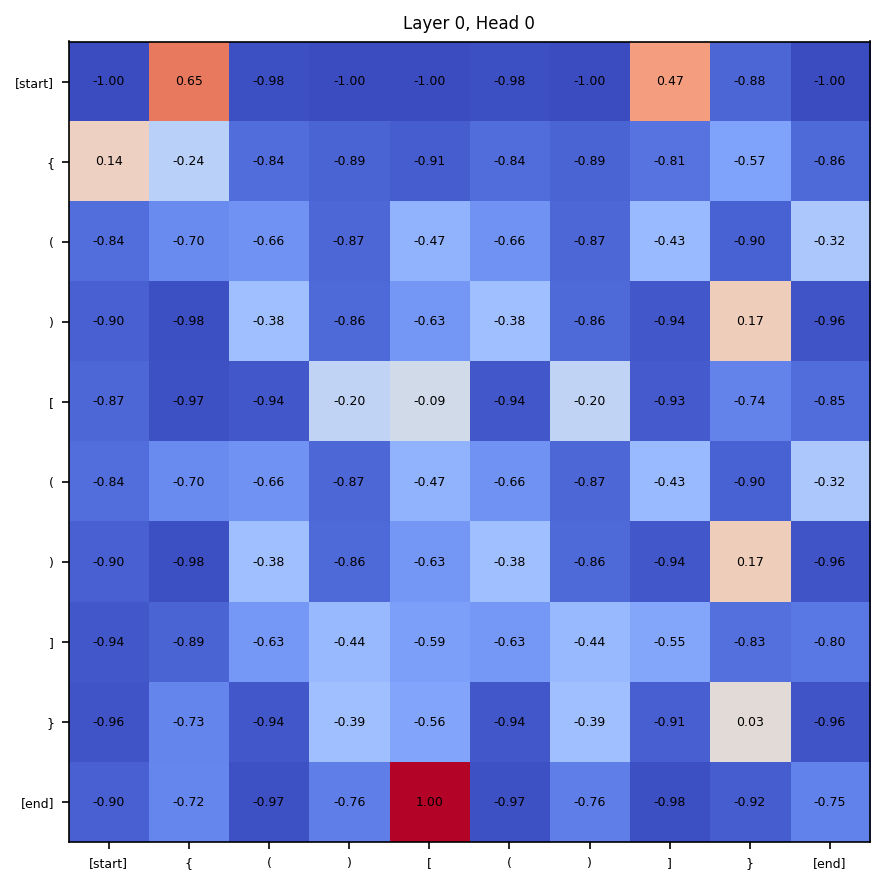

In [47]:
plot_attn_matrices(VOCAB, batch, model, min_max_normalize, pad_token_mask)

# Out of Distribution Dyck-3

In [48]:
k = 3

In [49]:
dyck_3_train_dataset = generate_dataset(
    n=50_000,
    k=3,
    min_length=0,
    max_length=96,
    balanced=0.5,
)

File data/dyck-3_50000-samples_96-len_p05.jsonl already exists.


In [50]:
dyck_3_train_dataset

'data/dyck-3_50000-samples_96-len_p05.jsonl'

In [51]:
VOCAB = "".join(
    ["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]]
)
VOCAB

'()[]{}'

In [52]:
dyck_3_train = DyckLanguageDataset(dyck_3_train_dataset, VOCAB).to(device)

train_dataset, val_dataset = random_split(
    dyck_3_train, [0.8, 0.2]
)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

Loaded 50000 samples from data/dyck-3_50000-samples_96-len_p05.jsonl


Tokenizing strings: 100%|██████████| 50000/50000 [00:00<00:00, 73595.93it/s]


In [53]:
ood_model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=256,
    n_heads=1,
    dim_ff=320,
    n_layers=2,
    n_classes=2,
    max_seq_len=128,
)

ood_model = TransformerClassifier(ood_model_config).to(device)

In [54]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(ood_model.parameters(), lr=1e-4)

In [55]:
train_loss, train_acc, val_loss, val_acc = ood_model.train_model(
    device=device,
    epochs=10,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/10


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.1030 | Train Accuracy: 88.52%
Train Loss: 0.0011 | Train Accuracy: 93.97%
Train Loss: 0.0003 | Train Accuracy: 95.98%
Train Loss: 0.0001 | Train Accuracy: 96.98%
Train Loss: 0.0000 | Train Accuracy: 97.59%
Train Loss: 0.0182 | Train Accuracy: 96.99%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.7076 | Validation Accuracy: 99.83%
Train Loss: 49.5066 | Train Acc: 97.04%
Val Loss: 0.9543 | Val Acc: 99.85%
Epoch 2/10


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0009 | Train Accuracy: 99.89%
Train Loss: 0.0003 | Train Accuracy: 99.95%
Train Loss: 0.4917 | Train Accuracy: 98.15%
Train Loss: 0.0020 | Train Accuracy: 98.25%
Train Loss: 0.0009 | Train Accuracy: 98.60%
Train Loss: 0.0006 | Train Accuracy: 98.83%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0183 | Validation Accuracy: 100.00%
Train Loss: 22.7317 | Train Acc: 98.88%
Val Loss: 0.0277 | Val Acc: 100.00%
Epoch 3/10


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0019 | Validation Accuracy: 100.00%
Train Loss: 0.1167 | Train Acc: 100.00%
Val Loss: 0.0029 | Val Acc: 100.00%
Epoch 4/10


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0011 | Validation Accuracy: 100.00%
Train Loss: 0.0425 | Train Acc: 100.00%
Val Loss: 0.0017 | Val Acc: 100.00%
Epoch 5/10


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0008 | Validation Accuracy: 100.00%
Train Loss: 0.0264 | Train Acc: 100.00%
Val Loss: 0.0012 | Val Acc: 100.00%
Epoch 6/10


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0006 | Validation Accuracy: 100.00%
Train Loss: 0.0194 | Train Acc: 100.00%
Val Loss: 0.0009 | Val Acc: 100.00%
Epoch 7/10


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0004 | Validation Accuracy: 100.00%
Train Loss: 0.0136 | Train Acc: 100.00%
Val Loss: 0.0007 | Val Acc: 100.00%
Epoch 8/10


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0004 | Validation Accuracy: 100.00%
Train Loss: 0.0105 | Train Acc: 100.00%
Val Loss: 0.0006 | Val Acc: 100.00%
Epoch 9/10


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0003 | Validation Accuracy: 100.00%
Train Loss: 0.0082 | Train Acc: 100.00%
Val Loss: 0.0005 | Val Acc: 100.00%
Epoch 10/10


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0003 | Validation Accuracy: 100.00%
Train Loss: 0.0066 | Train Acc: 100.00%
Val Loss: 0.0004 | Val Acc: 100.00%


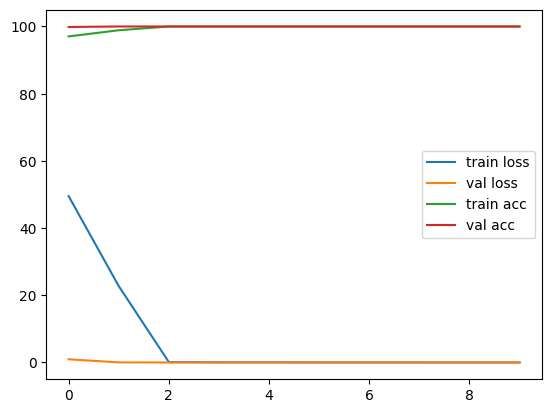

In [56]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

In [57]:
dyck_3_test_dataset = generate_dataset(
    n=10_000,
    k=3,
    min_length=32,
    max_length=128,
    balanced=0.5,
)

File data/dyck-3_10000-samples_128-len_p05.jsonl already exists.


In [58]:
dyck_3_test = DyckLanguageDataset(dyck_3_test_dataset, VOCAB).to(device)
test_dataloader = DataLoader(dyck_3_test, batch_size=8, shuffle=True)


Loaded 10000 samples from data/dyck-3_10000-samples_128-len_p05.jsonl


Tokenizing strings: 100%|██████████| 10000/10000 [00:00<00:00, 92102.14it/s]


In [59]:
test_loss, test_acc = ood_model.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/1250 [00:00<?, ?it/s]

Test Loss: 205.1708 | Test Accuracy: 83.12%
Test Loss: 437.2366 | Test Accuracy: 82.00%
Test Loss: 655.8001 | Test Accuracy: 82.04%
Test Loss: 890.6229 | Test Accuracy: 81.72%
Test Loss: 1128.2762 | Test Accuracy: 81.45%
Test Loss: 1349.2401 | Test Accuracy: 81.50%
Test Loss: 1584.6184 | Test Accuracy: 81.38%
Test Loss: 1813.2027 | Test Accuracy: 81.36%
Test Loss: 2030.2931 | Test Accuracy: 81.44%
Test Loss: 2255.7334 | Test Accuracy: 81.45%
Test Loss: 2523.6178 | Test Accuracy: 81.14%
Test Loss: 2743.9326 | Test Accuracy: 81.20%
Test Loss: 2850.1316 | Test Acc: 81.25%


test/acc,█▅▃▆▄▄▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁
test/loss,▅▃▄▃▄▃▆██▁▃▄▁▃▄▁▁▃▆▄▆▃▃▃▄█▆▃▁▁▄▄▆▄▄▄▁▃▄▄
test_acc,▁
test_loss,▁
train/acc,▁▅▆▇██▇▇████████████████████████████████
train/loss,█▁▁▁▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,█▅▁▂████████████████████████████████████
val/loss,▁▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/acc,81.25
test/loss,0.0
test_acc,81.25
